## Global reforestation map from Griscom et al. 2017

Author: Firza Riany
Email: firza.riany@climateanalytics.org  
Date: 08.07.2021 - 12.07.2021

Aim(s) of analysis:  
- Understanding forest distribution from Griscom's global forest map  

Datasets: 
- Griscom's global forest map: `NCS_Refor11_map.tif`
- World borders: `TM_WORLD_BORDERS-0`  

Citation:  
Bronson W. Griscom, et. al. (2017). Global Reforestation Potential Map [Data set]. Zenodo. http://doi.org/10.5281/zenodo.883444

Description:  
The map covers the potential areas where reforestation can take place, it does not consider the amount of natural forests/protection forests. The distribution is rather optimistic for the period 2030 - 2050 even after constraining it with food security and biodiversity safeguards. Griscom assumed no reduction in existing cropland area, but assumed grazing lands in forested ecoregions can be reforested, consistent with agricultural intensification and diet change scenarios

In [1]:
# libraries
import rasterio as rio  # to deal with raster data
from rasterio.plot import show  # plotting
from rasterio.mask import mask  # masking raster to polygon
import geopandas as gpd  # to deal with polygon/shapefiles data
import os
import matplotlib.pyplot as plt

In [39]:
import numpy as np

In [2]:
# checking current work directory
os.getcwd()

'/Users/firzariany/Documents/ikea_land_use/unstaged_scripts'

In [3]:
# input raster file, global reforestation map
in_tif = "data/reforest_griscom/NCS_Refor11_map.tif"

In [4]:
# open the raster in read mode
src = rio.open(in_tif)

In [5]:
# src.meta

In [6]:
# checking raster's crs
src.crs

CRS.from_wkt('PROJCS["World_Cylindrical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Cylindrical_Equal_Area"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [7]:
# set a new crs
src.crs.to_proj4()

'+proj=cea +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs=True'

In [8]:
# world borders to mask the raster
reg_file = "data/image_gridded/TM_WORLD_BORDERS-0"

regions = gpd.read_file(reg_file)

# convert to same coordinate system as raster
regions = regions.to_crs(src.crs.to_proj4())

In [9]:
# read and plot raster in small res
small = src.read(1,
                out_shape = (int(src.height / 4), int(src.width / 4)),
                masked = True)

# transform = src.transform * src.transform.scale(4)

Text(0.5, 1.0, 'Global reforestation map')

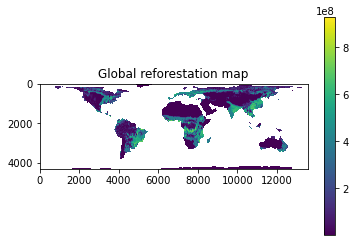

In [10]:
plt.imshow(small)
plt.colorbar()
plt.title("Global reforestation map".format(small.shape))

In [11]:
# small = masked_array dataset
# fill_value = 2147483647 represents missing value
# small

In [12]:
small.sum()

2653597702104328

---

In [34]:
# function to mask the reforestation map to country level
def dist_masked(source_tif, reg_name, output_path):
    reg = reg_name # object containing country borders
    g_reg = reg.geometry # get the geometry from reg
    out_img, out_transform = mask(source_tif, g_reg, crop=True) # mask the source raster with the geometry of country borders
    out_meta = source_tif.meta.copy() # copy the meta from source for masked raster
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform}) # update the output raster
    
    with rio.open(output_path, "w", **out_meta) as dest:
        dest.write(out_img) # save output as another raster
        
    open_masked = rio.open(output_path)
    
    return open_masked

dist_masked takes the source raster and crop it to country borders. the cropped map will be saved somewhere in the machine that's why it asks for output path. the function then open the cropped map saved in the machine.  

Parameters:  
- source_tif = a source or an input raster, geoTIFF  
- reg_name = country borders from shapefile containing geometry information, object-like  
- output_path = path/<name_of_the_output.tif>, str data type  

Returns:  
- a raster file in geoTIFF format cropped to country level

---

In [35]:
br = regions[regions.ISO3 == "BRA"]
out_br = "data/reforest_griscom/NCS_Refor_br2.tif"

open_br = dist_masked(source_tif=src, reg_name=br, output_path=out_br)

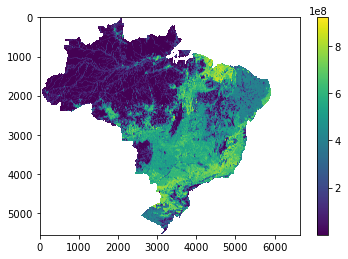

In [36]:
# plotting with color legend
read_br = open_br.read(1, masked=True)

plt.imshow(read_br)
plt.colorbar();

In [48]:
# function for normalization
def normalize(source_read):
    plt_clean = np.where(source_read.data==2147483647, 0, source_read) # where data equals to that value, replace with 0 in var dataset
    plt_norm = plt_clean.data / plt_clean.max() # normalizing, values divided by the max. results = probability 0 - 1
    total = plt_norm.sum()
    return total

normalize cleans the raster values and normalizes to probability values ranging from 0 - 1. probability values refer to the probability that a cell is covered by forest, 0 when the cell is not covered by forest, 1 is when it is fully covered by forests. the function first replaces fill_value from the source tiff to 0 because this fill_value represents missing values. then it divides each value in the dataset with the max value to produce 0 - 1 probabilities. 

the function returns the sum of cell where value is more than 0. because the cell resolution is 1x1 km2, a value of 1 in one cell = 1 km2, hence the sum of cell where value is more than 0 equals to the total area of forest.  

Parameter:  
- source_read = a masked array, after the source tiff is being read  

Returns:  
Total forest area at country level

In [51]:
# reforestation potential, results in km2
normalize(source_read=read_br)

4811268.540821588